In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization

from tqdm import tqdm


Using TensorFlow backend.


In [90]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)

# take in data
df_train = pd.read_csv("aptos2019-blindness-detection/train.csv") 
df_test  = pd.read_csv("aptos2019-blindness-detection/test.csv")


In [91]:
IMG_DIM      = 299 #512
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_EPOCHS   = 12
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()

CLASSS={0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}

df_train.columns, NUM_CLASSES


(Index(['id_code', 'diagnosis'], dtype='object'), 5)

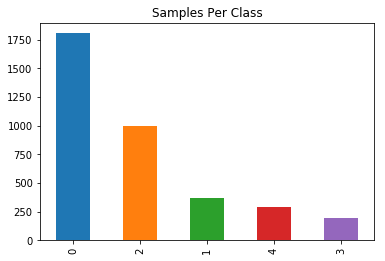

In [92]:
df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');


In [93]:
x_train, x_test, y_train, y_test=train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2, random_state =SEED, stratify=df_train.diagnosis)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((2929,), (2929,), (733,), (733,))

(2136, 3216, 3)


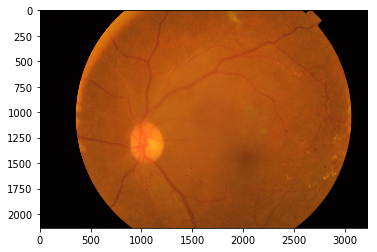

In [94]:
# sample image
imgPath = f"aptos2019-blindness-detection/train_images/cd54d022e37d.png"
img = cv2.imread(imgPath)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

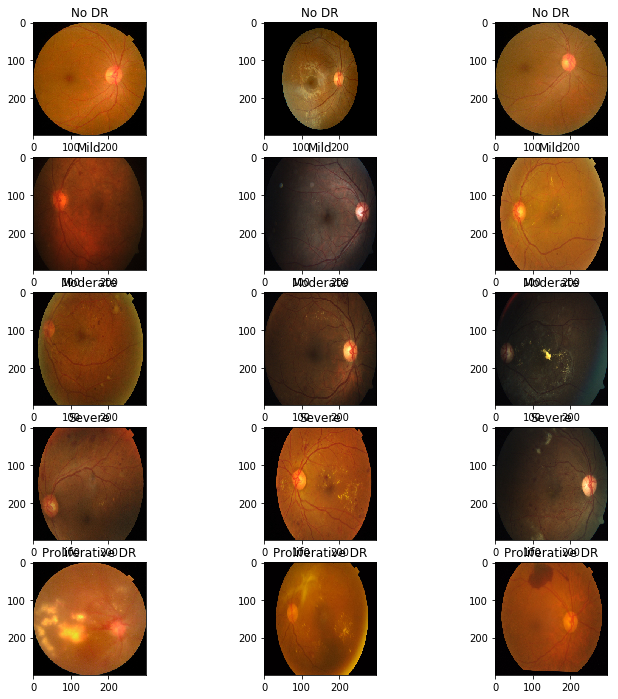

In [7]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(20,12))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(3, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5,5, target_class*5+i+1)
        imagefile = f"aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img = cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_DIM,IMG_DIM))
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])
#     plt.show()

In [76]:

def squareUp(y, ycc):
    
    thresh = 5
    
    # remove any black regions, where black is y under the threshold
    rowMaxes = y.max(axis=1)
    top = 0
    while rowMaxes[top] < thresh:
        top += 1
    bottom = len(rowMaxes) - 1
    while rowMaxes[bottom] < thresh:
        bottom -= 1
        
    middleRow = y[int((bottom-top)/2)]
    left = 0
    while middleRow[left] < thresh:
        left += 1
    right = len(middleRow) - 1
    while middleRow[right] < thresh:
        right -= 1
        
    height = bottom - top
    width  = right - left
        
    if height < 100 or width < 100:
        print("Error: squareUp: bottom:", bottom, "top:", top)
        print("Error: squareUp: right:", right, "left:", left)
        return ycc
    
    # Make a blank canvas, of the size of a square of the larger of the above
    length = max(height, width)
    blank_image = np.full((length, length, 3), 128, np.uint8)
    blank_image[:,:,0] = 0 # black in ycc is 0 128 128
    
    ycc = ycc[top:bottom, left:right]
    v_offset  = int((length - height)/2)
    h_offset = int((length - width)/2)
    blank_image[v_offset:v_offset+height, h_offset:h_offset+width] = ycc
    
    return blank_image
    
    

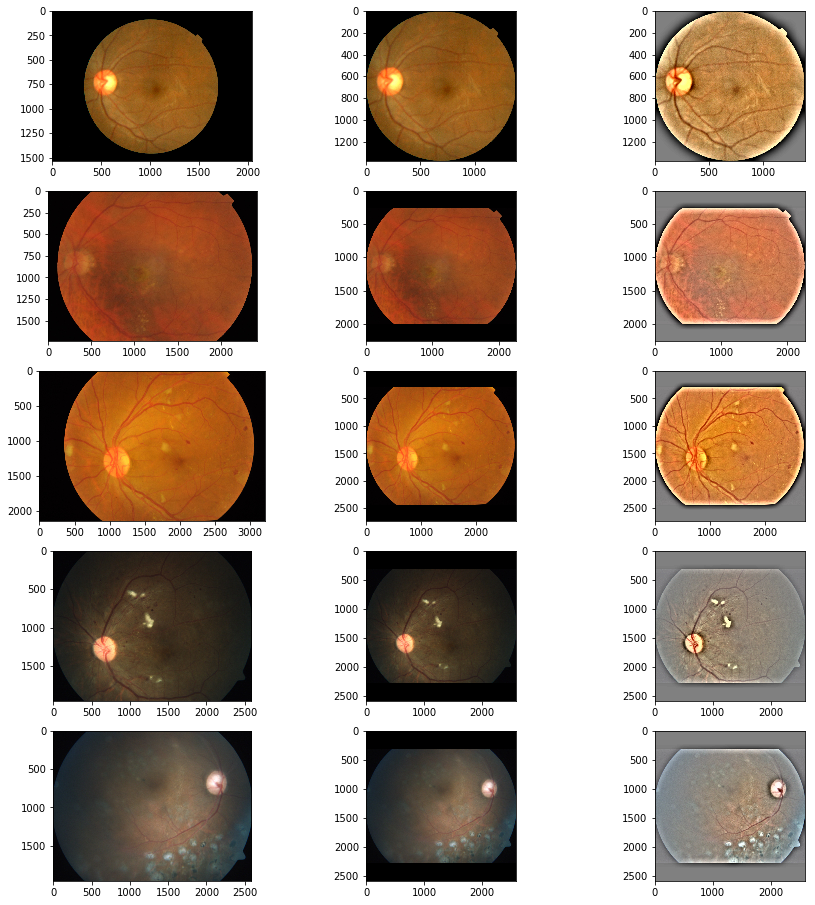

In [84]:
# Display some random images from Data Set with class categories. showig Gray image removing other channel and adding lighting to image.
figure=plt.figure(figsize=(25,16))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(4, random_state=345).iterrows()):

        
        # open the file
        imagefile=f"aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img = cv2.imread(imagefile)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
        ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycc)
        
        # remove and add black to square the image
        ycc = squareUp(y, ycc)
        y, cr, cb = cv2.split(ycc)
        
        # perform bens algorithm on the y component
        y = cv2.addWeighted(y, 3, cv2.GaussianBlur(y, (0,0), 60),-3, 128)
        
        # merge the ycc back together, and recolor it
        ycc_modified = cv2.merge((y, cr, cb))
        rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
        rgb_cropped = cv2.cvtColor(ycc, cv2.COLOR_YCrCb2RGB)
        
#         img = cv2.resize(img,(IMG_DIM,IMG_DIM))
        ax = figure.add_subplot(5,5, target_class*5+i+1)
        plt.imshow(rgb)
        ax = figure.add_subplot(5,5, target_class*5+i+2)
        plt.imshow(rgb_cropped)
        ax = figure.add_subplot(5,5, target_class*5+i+3)
        plt.imshow(rgb_modified)
        break
#     break
#     plt.show()


In [85]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1] 
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1) 
    img=img[y:(y+dy), x:(x+dx), :] 
    return img
    
"""Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """  
def crop_generator(batches, crop_length):    
    while True:
        batch_x, batch_y=next(batches)
        batch_crops=np.zeros((batch_x.shape[0],crop_length,3))
        for i in range(batch_x.shape[0]):
            batch_crops[0]=random_crop(batch_x[i],(crop_length, crop_length))
        yield (batch_crops, batch_y)
 

In [95]:
gc.collect()

df_train.id_code=df_train.id_code.apply(lambda x: x+".png")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')


In [96]:
# train_datagen=image.ImageDataGenerator(rescale=1./255,
#                                        validation_split=0.15,
#                                        horizontal_flip=True,
#                                        vertical_flip=True,
#                                        shear_range=0.1,
#                                        zoom_range=0.1)
#                                        featurewise_center=True, 
#                                        featurewise_std_normalization=True
train_datagen=image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True)

# valid_datagen=image.ImageDataGenerator(rescale=1./255)


In [97]:
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="aptos2019-blindness-detection/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='training', 
                                                  shaffle=False,
                                                  seed=SEED,
                                                 )
valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="aptos2019-blindness-detection/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='validation',
                                                  shaffle=False,
                                                  seed=SEED
                                                 )
del x_train 
del y_train
gc.collect()


Found 2930 images belonging to 5 classes.
Found 732 images belonging to 5 classes.


57

In [101]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr  = ReduceLROnPlateau(monitor='val_loss',  min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6,  mode='auto', verbose=1)

NUB_TRAIN_STEPS=train_generator.n//train_generator.batch_size
NUB_VALID_STEPS=valid_generator.n//valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS


(91, 22)

In [102]:
def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor=Input(shape=(img_dim, img_dim, CHANNEL))
  
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('resnet50weightsfile/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)
    
    return model_resnet

model_resnet=create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [103]:
for layers in model_resnet.layers:
    layers.trainable=True

lr = 1e-3
optimizer = rmsprop(lr=lr, decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model.summary()
gc.collect()

365

In [105]:
history=model_resnet.fit_generator(generator=train_generator,
                           steps_per_epoch=NUB_TRAIN_STEPS,
                           validation_data=valid_generator,
                           validation_steps=NUB_VALID_STEPS,
                           epochs=NUM_EPOCHS,
#                            shuffle=True,  
                           callbacks=[early_stop, reduce_lr],
                           verbose=2)
gc.collect()


Instructions for updating:
Use tf.cast instead.
Epoch 1/12


KeyboardInterrupt: 